<a href="https://colab.research.google.com/github/B-Lorentz/riverine/blob/master/py/sph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from jax import grad, vmap, jit, lax
from jax import numpy as jnp
from jax import random as rand
import jax
import functools as func
from dataclasses import dataclass

In [2]:
import pathlib
def once_in_a_VM(fname):
  pat = pathlib.Path(fname)
  if pat.exists():
      return False
  else:
    pat.mkdir()
    return True
if once_in_a_VM("download"):
  !git clone https://github.com/B-Lorentz/riverine.git

fatal: destination path 'riverine' already exists and is not an empty directory.


In [4]:
if once_in_a_VM("install"):
  !pip install -e riverine/py

Obtaining file:///content/riverine/py
  Found existing installation: riverine 0.0
    Can't uninstall 'riverine'. No files were found to uninstall.
  Running setup.py develop for riverine


In [5]:
from utils.height_field import *

(20, 10) (20, 10)
(20, 10) (20, 10)


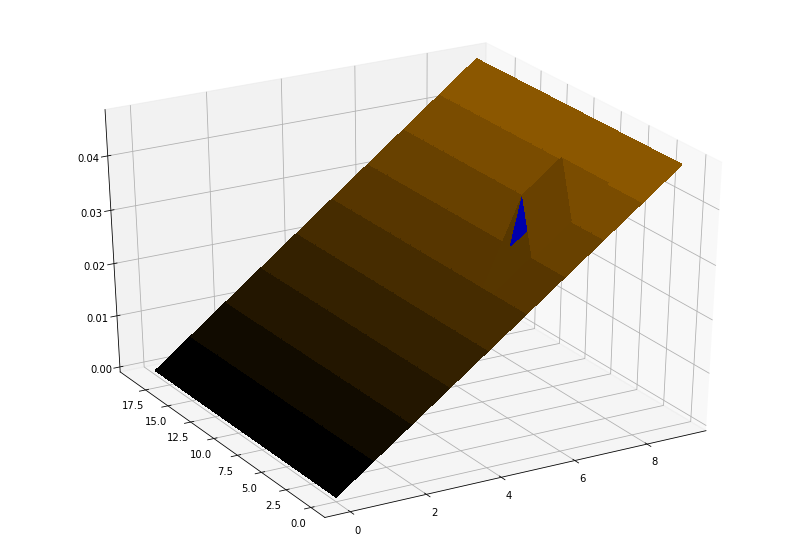

In [6]:

def show_terrain(b, d, threshold=1e-7):
  print(d.shape, b.shape)
  fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(14, 10))
  x, y = np.meshgrid(np.arange(b.shape[1]), np.arange(b.shape[0]))
  print(x.shape, y.shape)
  color = np.array([0.0,0.0,0.9])*((d>threshold)*(0.1 + (b+d)/(b+d).max()))[:,:,np.newaxis] + np.array([0.8, 0.5, 0])*(b/b.max()*(d<threshold))[:,:,np.newaxis]
  surf = ax.plot_surface(x, y, b+d, facecolors=color, antialiased=False, shade=True)
  return ax

h = tilt_hf(20, 0.1, 0.0)[:,:10]
w = np.zeros_like(h)+.0
w[4, 6] = 0.01 
w[4, 7] = 0.01 
ax = show_terrain(h, w)
ax.view_init(30, -120)

An eulerian 2D method using shallow-water equations:
Mei, Decaudin & Hu:
*Fast Hydraulic Erosion Simulation and Visualization on GPU*

-1.7881393e-07
0.1218317
-0.058284283 0.020792685
(20, 10)
0.02 -7.450581e-09


/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


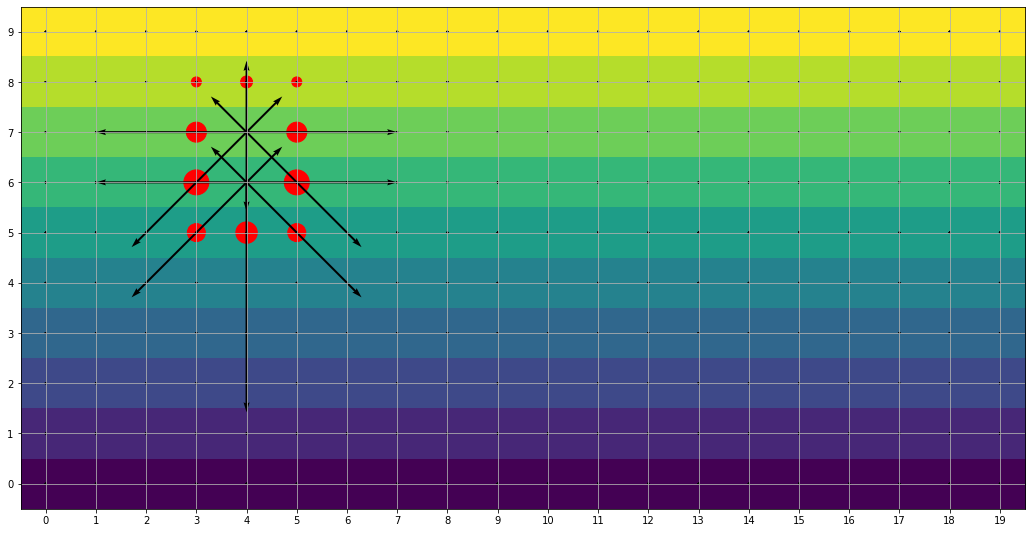

In [7]:
dirs = np.array([[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]])
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
def flow_init(h, dirs):
  return np.zeros((dirs.shape[0], *h.shape))

def flow_conv(h, w, dirs):
  kernel = np.zeros((dirs.shape[0], 1, 3, 3))
  for i, dir in enumerate(dirs):
    d = np.sqrt(np.power(dir, 2).sum())
    kernel[i, 0, 1, 1] += 1/d
    kernel[i, 0, 1+dir[0], 1+dir[1]] += -1/d
 
  res = lax.conv(jnp.pad(h + w, ((1, 1), (1, 1)), mode="edge")[np.newaxis,np.newaxis,:,:], kernel, (1,1),padding="VALID").squeeze()
 
  return res

def collect_conv(f, dirs):
  kernel = np.zeros((1, dirs.shape[0], 3, 3))
  for i, dir in enumerate(dirs):
    kernel[0, i, 1, 1] += -1.0
    kernel[0, i, 1-dir[0], 1-dir[1]] += 1.0
  
  res = lax.conv(jnp.pad(f, ((0,0),(1, 1), (1, 1)), mode="edge")[np.newaxis,:,:,:], kernel, (1,1),padding="VALID", precision=lax.Precision.HIGHEST).squeeze()
  return res

def f_scale(f, w, dt):
  f = jnp.maximum(f, 0.0)
  return f*jnp.minimum(1.0, w/(dt * (f.sum(0) + 1e-9)))
def flow_quiver(h, w, f, markers = ([], [])):
  plt.figure(figsize=(18, 10))
  x, y = np.meshgrid(np.arange(h.shape[-2]), np.arange(h.shape[-1]))
 
  plt.imshow(h.T, origin="lower", )
  plt.scatter(x.T, y.T, s=3000*w, c="r")
  plt.scatter(markers[0], markers[1], s=100, marker="x" )
  plt.gca().xaxis.set_major_locator(MultipleLocator(1))
  plt.gca().yaxis.set_major_locator(MultipleLocator(1))
  plt.grid()
  print(h.shape)
  for dir, f_ in zip(dirs, f):
    d = np.sqrt(np.power(dir, 2).sum())
    plt.quiver(x.T, y.T, dir[0]*f_/d, dir[1]*f_/d, scale=1, units="xy", width=0.04, headlength=5)
 
 
f = flow_init(h, dirs)
f[1] = 1.0
f = flow_conv(h, w, dirs)
print(f.sum())
f = f_scale(f, w, 0.1)
print(f.sum())
w1 = collect_conv(f, dirs)
print(w1.min(), w1.max())
flow_quiver(h, 10*(w+w1), f*300)
print(w.sum(), w1.sum())

In [8]:
def make_update(source, gA, nu, dt, dirs):
  l = np.sqrt(np.power(dirs, 2).sum(-1))
  def update(h, w, f, s):
    h = h + source*dt
    df = gA*flow_conv(h, w, dirs) - nu*f
    f = f + dt*df
    f = f_scale(f, w, dt)
    w = w + collect_conv(f, dirs)*dt
    
    return h, w, f, s, 0
  return update

In [9]:

def trace_sim(update, h, w, N):
  s = np.zeros_like(h)
  f = flow_init(h, dirs)
  
  def upd(state, _):
    h, w, f, s, log= update(*state)
    return ((h, w, f, s), (w, log),)
  end, (story, log) = jax.lax.scan(jit(upd), (h, w, f, s), xs=None, length=N)
  return end, story, log 

In [10]:
res, story, log = trace_sim(make_update(0, 9.81, 0.1, 0.1, dirs), h, w, 10)

(20, 10) (20, 10)
(20, 10) (20, 10)


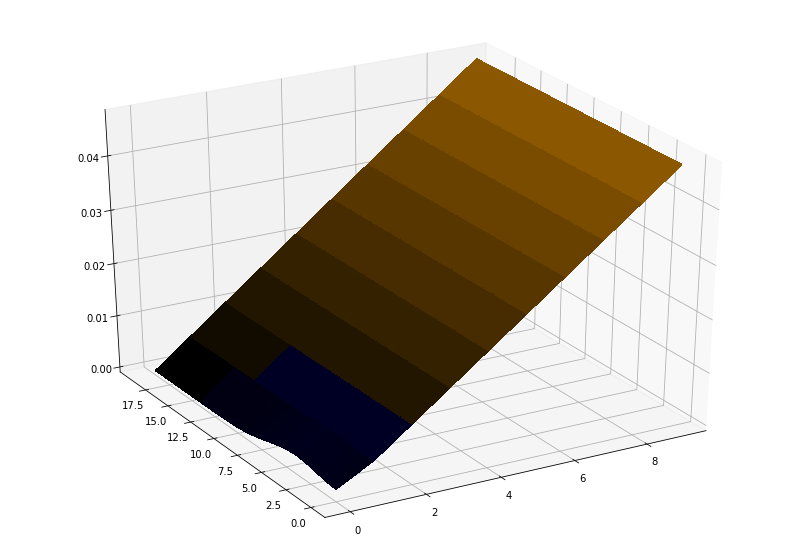

In [11]:
ax = show_terrain(h, story[200])
ax.view_init(30, -120)

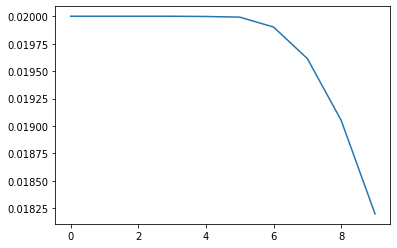

In [12]:
plt.plot(story.sum(-1).sum(-1))

(100, 100) (100, 100)
(100, 100) (100, 100)


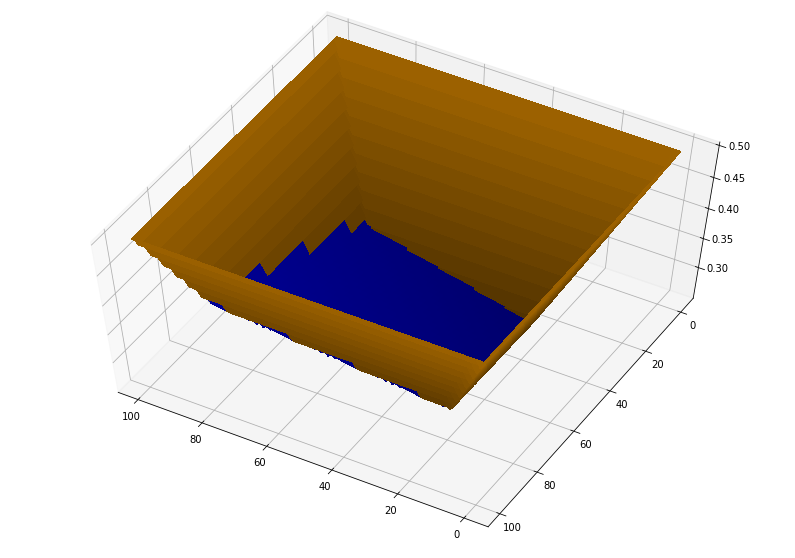

In [13]:
N = 100
h = basin_hf(N)
w = np.maximum(tilt_hf(N, 0.1, 0.1)+0.2-h,0)

ax = show_terrain(h, w)
ax.view_init(60, 120)

In [14]:
res, story, log = trace_sim(make_update(0, 1*9.81, 0.1, 0.1, dirs), h, w, 1000)

In [15]:
story = story.to_py()

(100, 100) (100, 100)
(100, 100) (100, 100)


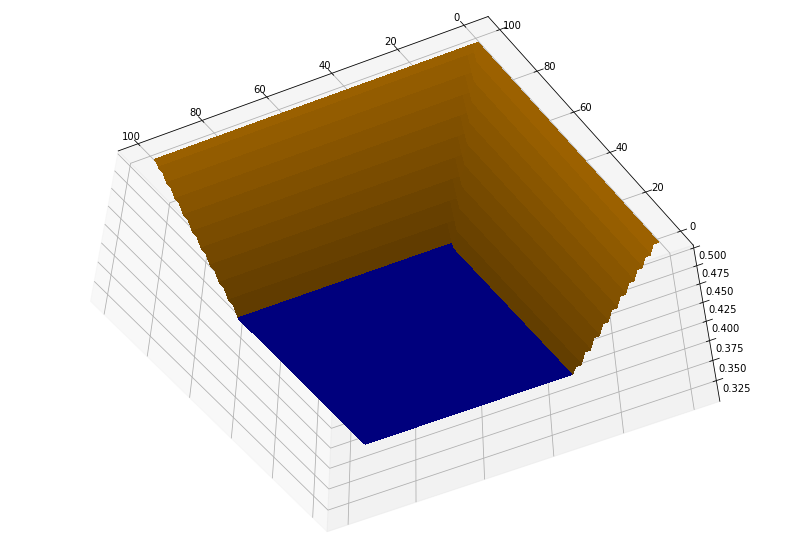

In [16]:
ax = show_terrain(h, story[-1])
ax.view_init(-60, 120)

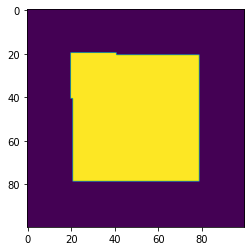

In [17]:
plt.imshow(story[300]>0.01)

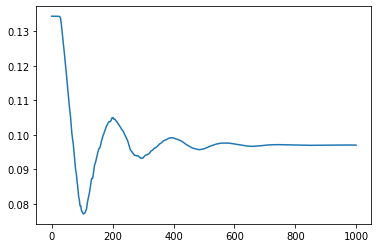

In [18]:
plt.plot(story[:, 70, 70])